# Credit Card Default Prediction

## Introduction
This notebook explores credit card default prediction using machine learning. We'll analyze a dataset containing credit card client data to predict whether a client will default on their payment.

### Dataset Overview
- 30,000 credit card clients
- Features include credit limit, gender, education, marital status, age, and payment history
- Target variable: default payment next month (1 = default, 0 = no default)

## 1. Data Loading and Initial Exploration
First we'll load our data and take a look at its structure

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
import numpy as np
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("./data/defaultofcreditcardclients.csv")

In [3]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

Number of rows: 30000
Number of columns: 25


In [4]:
print("Datas type")
print(df.dtypes)

Datas type
ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object


In [5]:
print("Missing Values")
print(df.isnull().sum()[df.isnull().sum() > 0])

Missing Values
Series([], dtype: int64)


In [6]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Exploratory Data Analysis 

## Labels distribution

<Axes: >

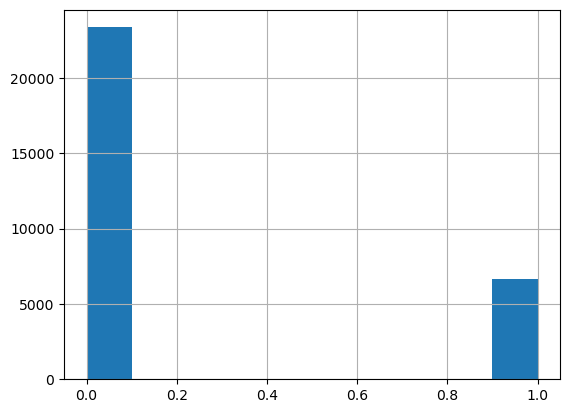

In [7]:
df['default payment next month'].hist()

## Correlation matrix

Text(0.5, 1.0, 'Correlation Matrix')

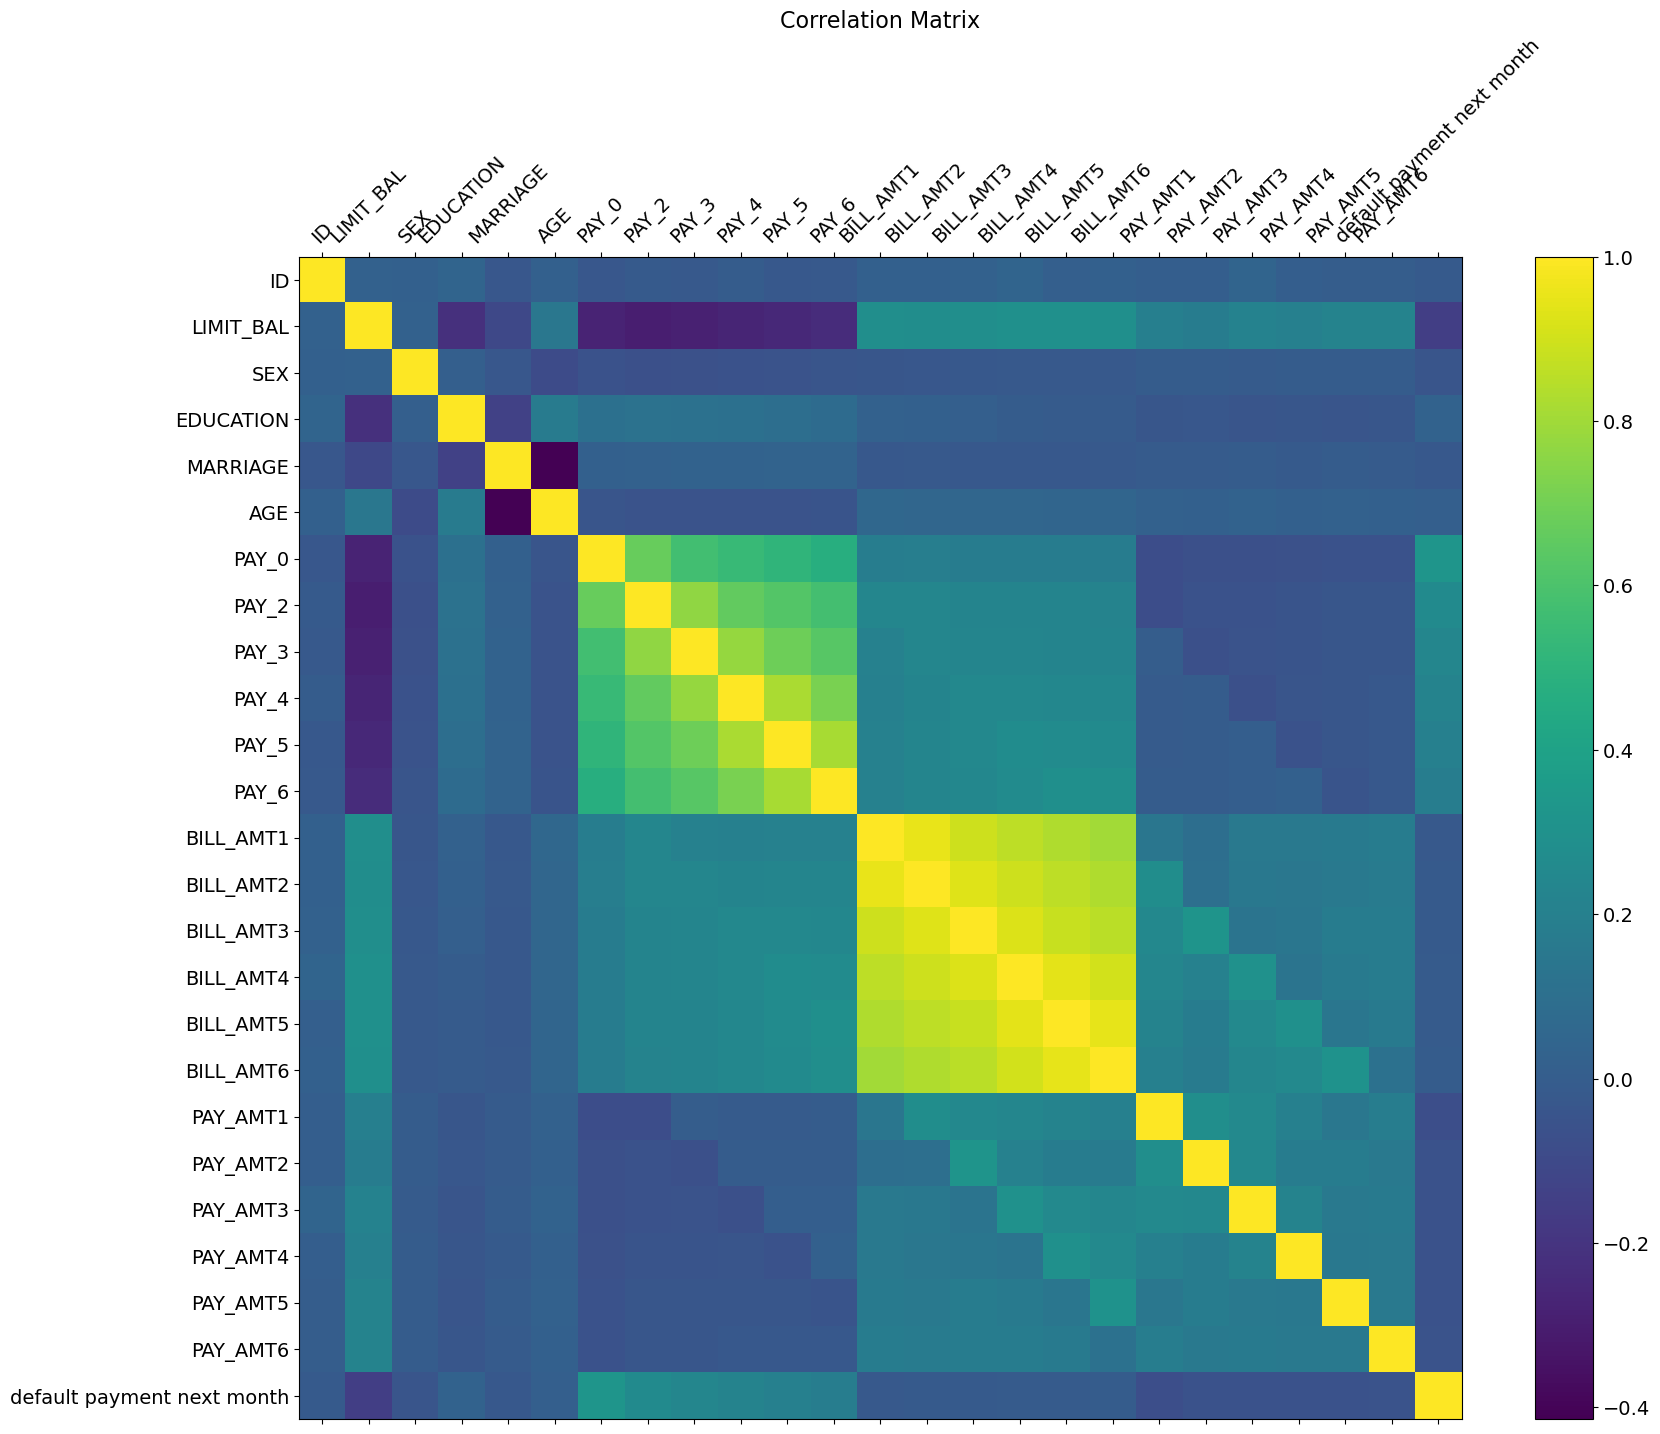

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## 3. Model Pipeline Development

We'll test three different models:
1. Support Vector Machine (SVM)
2. Random Forest
3. Logistic Regression

Each model will be tested using a standardized pipeline including:
- Feature scaling
- Cross-validation
- Hyperparameter tuning

In [9]:
y = df['default payment next month']
X = df.drop(['ID', 'default payment next month'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [11]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

In [12]:
param_grid = {
    # SVM parameters
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf'],
    
    # Random Forest parameters
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    
    # Logistic Regression parameters
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga'],
    'lr__max_iter': [1000]
}

In [13]:
models = {
    'Support Vector Machine': svm_pipeline,
    'Random Forest': rf_pipeline,
    'Logistic Regression': lr_pipeline
}

In [14]:
best_models = {}
all_results = {}


for name, model in models.items():
    print(f"\nPerforming grid search for {name}...")
    
    if name == 'Support Vector Machine':
        current_params = {key: value for key, value in param_grid.items() if key.startswith('svm')}
    elif name == 'Random Forest':
        current_params = {key: value for key, value in param_grid.items() if key.startswith('rf')}
    else:  # Logistic Regression
        current_params = {key: value for key, value in param_grid.items() if key.startswith('lr')}
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=current_params,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring=('accuracy', 'f1', 'f1_micro', 'f1_macro'),
        refit='f1'
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    y_pred = grid_search.predict(X_test)
    

    all_scores = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'f1_micro': f1_score(y_test, y_pred, average='micro'),
        'f1_macro': f1_score(y_test, y_pred, average='macro')
    }

    all_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'all_scores': all_scores,
        'test_predictions': y_pred,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }



Performing grid search for Support Vector Machine...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Performing grid search for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Performing grid search for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## 4. Model Evaluation

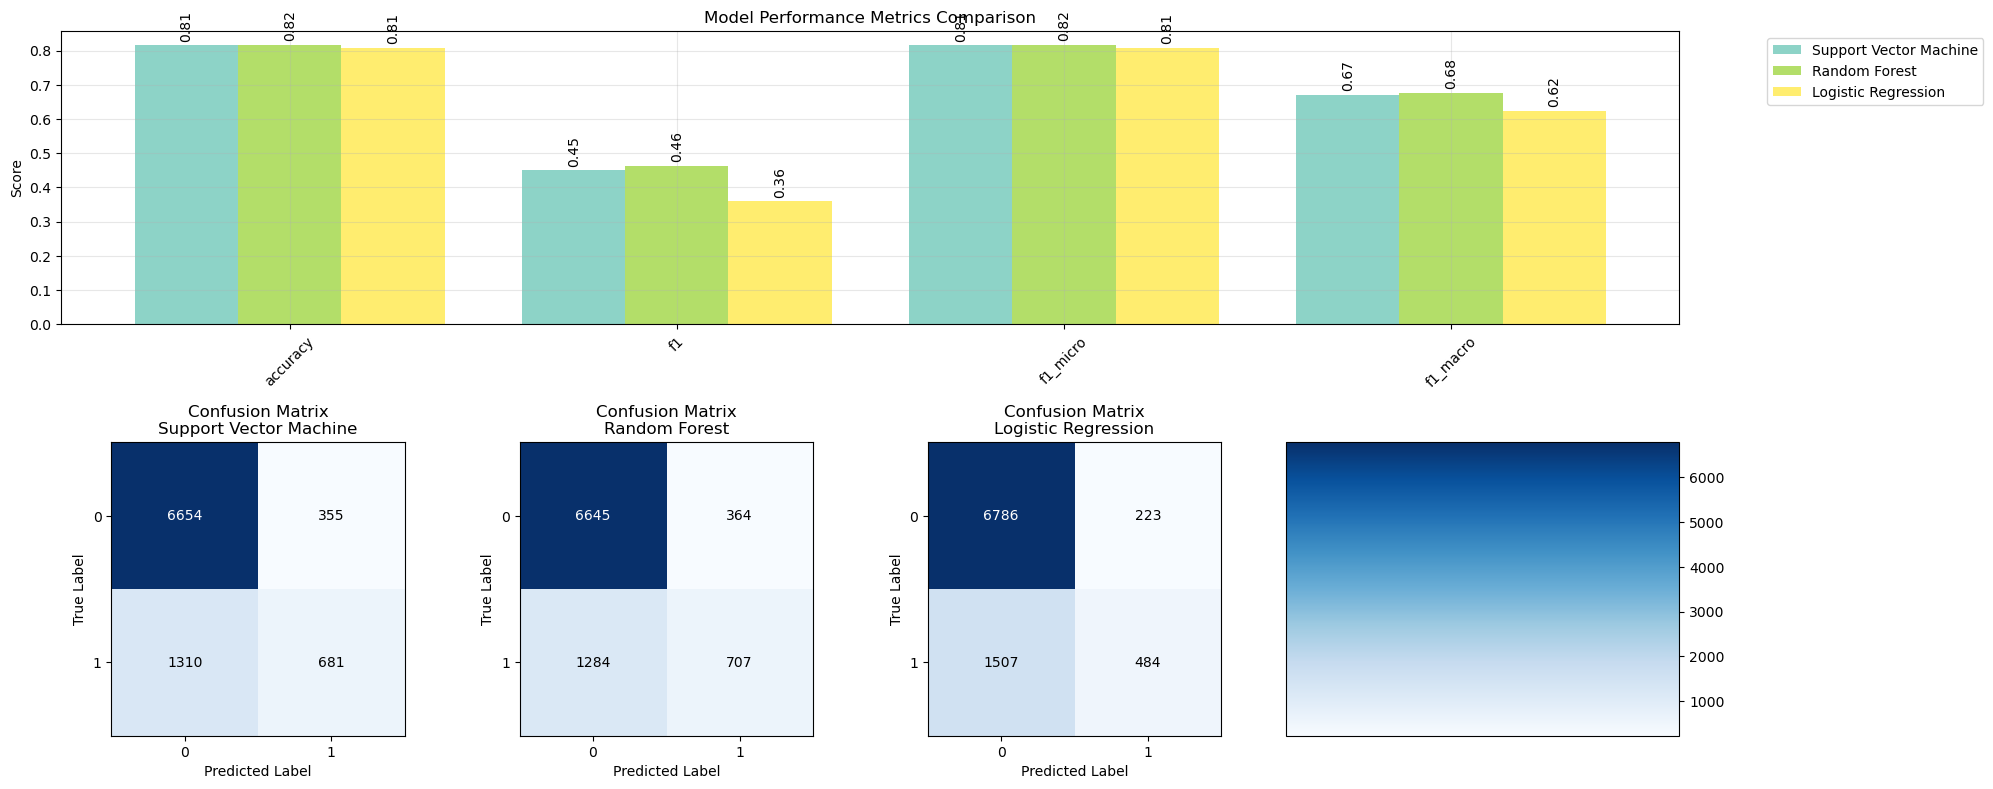

In [15]:
metrics = ['accuracy', 'f1', 'f1_micro', 'f1_macro']

scores = {}
for model_name, model_data in all_results.items():
    scores[model_name] = [
        model_data['all_scores']['accuracy'],
        model_data['all_scores']['f1'],
        model_data['all_scores']['f1_micro'],
        model_data['all_scores']['f1_macro']
    ]

num_models = len(all_results)
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, num_models + 1)

ax1 = fig.add_subplot(gs[0, :])

x = np.arange(len(metrics))
width = 0.8 / num_models  # Adjust bar width based on number of models
colors = plt.cm.Set3(np.linspace(0, 1, num_models))

for i, (model_name, model_scores) in enumerate(scores.items()):
    positions = x + width * (i - num_models/2 + 0.5)
    bars = ax1.bar(positions, model_scores, width, label=model_name, color=colors[i])
    
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)

ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

for i, (model_name, model_data) in enumerate(all_results.items()):
    ax = fig.add_subplot(gs[1, i])
    conf_matrix = model_data['confusion_matrix']
    
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix\n{model_name}')
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

cbar_ax = fig.add_subplot(gs[1, -1])
plt.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

All models demonstrate good accuracy, though F1 scores are lower across all models, with Random Forest performing the best. The micro F1 scores mirror the accuracy, and the macro F1 scores range between 0.63 and 0.69.

The three models show good true negative detection, with acceptable true positive rates, though they all exhibit high false positive rates. This can be attributed to an imbalanced dataset (identified during exploration with a label mean of 0.22, indicating a majority of 0s). All models struggle with true predictions. It may be necessary to increase the representation of true cases in the dataset.

The Random Forest model achieves the best balance among the three tested models.

## 5. Model Interpretability 
Let's analyze which features have the strongest influence on our predictions using SHAP (SHapley Additive exPlanations) values. On the best models: Random Forest

## First, using no SHAP

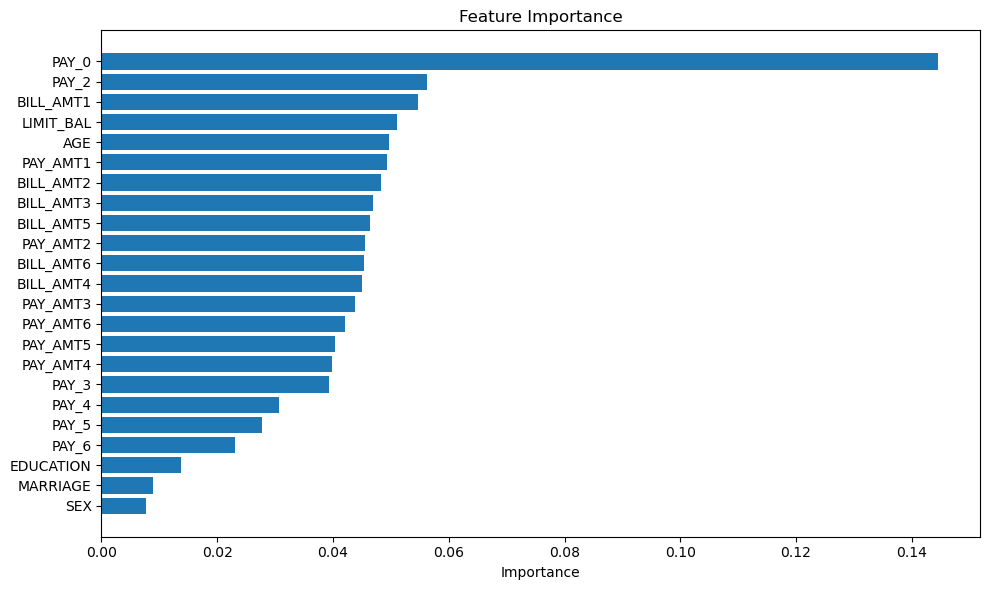

In [16]:
best_model_name = 'Random Forest'

best_model = best_models[best_model_name].named_steps['rf']

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)  # Ascending=True for horizontal bars to show highest at top

plt.figure(figsize=(10, 6))
plt.barh(importances_sorted.index, importances_sorted.values)

plt.title('Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()

## Using SHAP

In [17]:
explainer = shap.TreeExplainer(best_model)

In [18]:
shap_values = explainer.shap_values(X_test[:1])

<module 'matplotlib.pyplot' from '/nix/store/xih25y1md26h09z7qg5gh3k0kjmpz3js-python3-3.12.8-env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

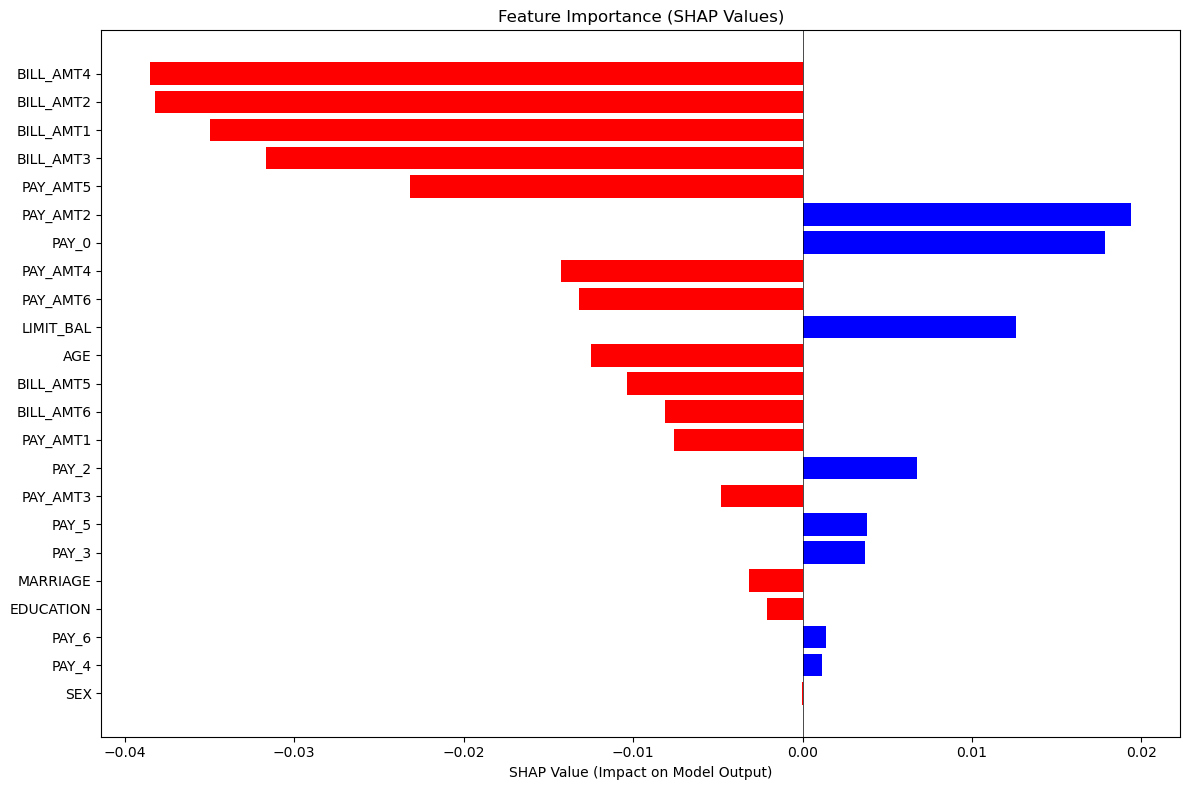

In [19]:
def plot_shap_values(shap_values, feature_names):
    values = shap_values[0][:, 0]
    
    plt.figure(figsize=(12, 8))
    
    sorted_idx = np.argsort(np.abs(values))
    
    y_pos = np.arange(len(values))
    plt.barh(y_pos, values[sorted_idx], 
            color=['red' if x < 0 else 'blue' for x in values[sorted_idx]])
    
    plt.yticks(y_pos, feature_names[sorted_idx], ha='right')
    plt.xlabel('SHAP Value (Impact on Model Output)')
    plt.title('Feature Importance (SHAP Values)')
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    return plt

plot_shap_values(shap_values, X_test.columns)

# 6. Improvement

In [20]:
df_improved = df

In [21]:
def remove_correlated_features(df, threshold=0.9, keep_columns=['default payment next month']):
    corr_matrix = df.corr().abs()
    
    to_drop = []
    
    for col1 in df.columns:
        if col1 in keep_columns:
            continue
            
        if col1 in to_drop:
            continue
            
        for col2 in df.columns:
            if (col1 == col2) or (col2 in keep_columns):
                continue
                
            if corr_matrix.loc[col1, col2] > threshold:
                col1_avg_corr = corr_matrix[col1].mean()
                col2_avg_corr = corr_matrix[col2].mean()
                
                if col1_avg_corr > col2_avg_corr:
                    to_drop.append(col1)
                else:
                    to_drop.append(col2)
    
    to_drop = list(to_drop)
    
    result = df.drop(columns=to_drop)
    
    print(f"Removed {len(to_drop)} correlated columns")
    return result

df_improved = remove_correlated_features(df_improved)

Removed 7 correlated columns


## SMOTE
SMOTE (Synthetic Minority Oversampling Technique) is a data augmentation method used in machine learning to address imbalanced datasets, where one class significantly outnumbers another

In [22]:
X = df_improved.drop('default payment next month', axis=1)
y = df_improved['default payment next month']

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_i, y_train_i = smote.fit_resample(X_train_i, y_train_i)

## Redo the whole pipeline

Pipeline and gridsearch and...

To check if the smote improve something

In [23]:
svm_pipeline_improved = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

rf_pipeline_improved = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

lr_pipeline_improved = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

In [24]:
param_grid_improved = {
    # SVM parameters
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf'],
    
    # Random Forest parameters
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    
    # Logistic Regression parameters
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga'],
    'lr__max_iter': [1000]
}

In [25]:
models_improved = {
    'Support Vector Machine': svm_pipeline_improved,
    'Random Forest': rf_pipeline_improved,
    'Logistic Regression': lr_pipeline_improved
}

In [26]:
best_models_improved = {}
all_results_improved = {}


for name, model in models_improved.items():
    print(f"\nPerforming grid search for {name}...")
    
    if name == 'Support Vector Machine':
        current_params = {key: value for key, value in param_grid_improved.items() if key.startswith('svm')}
    elif name == 'Random Forest':
        current_params = {key: value for key, value in param_grid_improved.items() if key.startswith('rf')}
    else:  # Logistic Regression
        current_params = {key: value for key, value in param_grid_improved.items() if key.startswith('lr')}
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=current_params,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring=('accuracy', 'f1', 'f1_micro', 'f1_macro'),
        refit='f1'
    )
    
    grid_search.fit(X_train_i, y_train_i)
    
    best_models_improved[name] = grid_search.best_estimator_
    y_pred_improved = grid_search.predict(X_test_i)

    confusion_matrix_model = confusion_matrix(y_test_i, y_pred_improved)

    all_scores_improved = {
        'accuracy': accuracy_score(y_test_i, y_pred_improved),
        'f1': f1_score(y_test_i, y_pred_improved, average='binary'),
        'f1_micro': f1_score(y_test_i, y_pred_improved, average='micro'),
        'f1_macro': f1_score(y_test_i, y_pred_improved, average='macro')
    }

    all_results_improved[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'all_scores': all_scores_improved,
        'test_predictions': y_pred_improved,
        'classification_report': classification_report(y_test_i, y_pred_improved),
        'confusion_matrix': confusion_matrix_model
    }



Performing grid search for Support Vector Machine...
Fitting 5 folds for each of 9 candidates, totalling 45 fits



Performing grid search for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Performing grid search for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


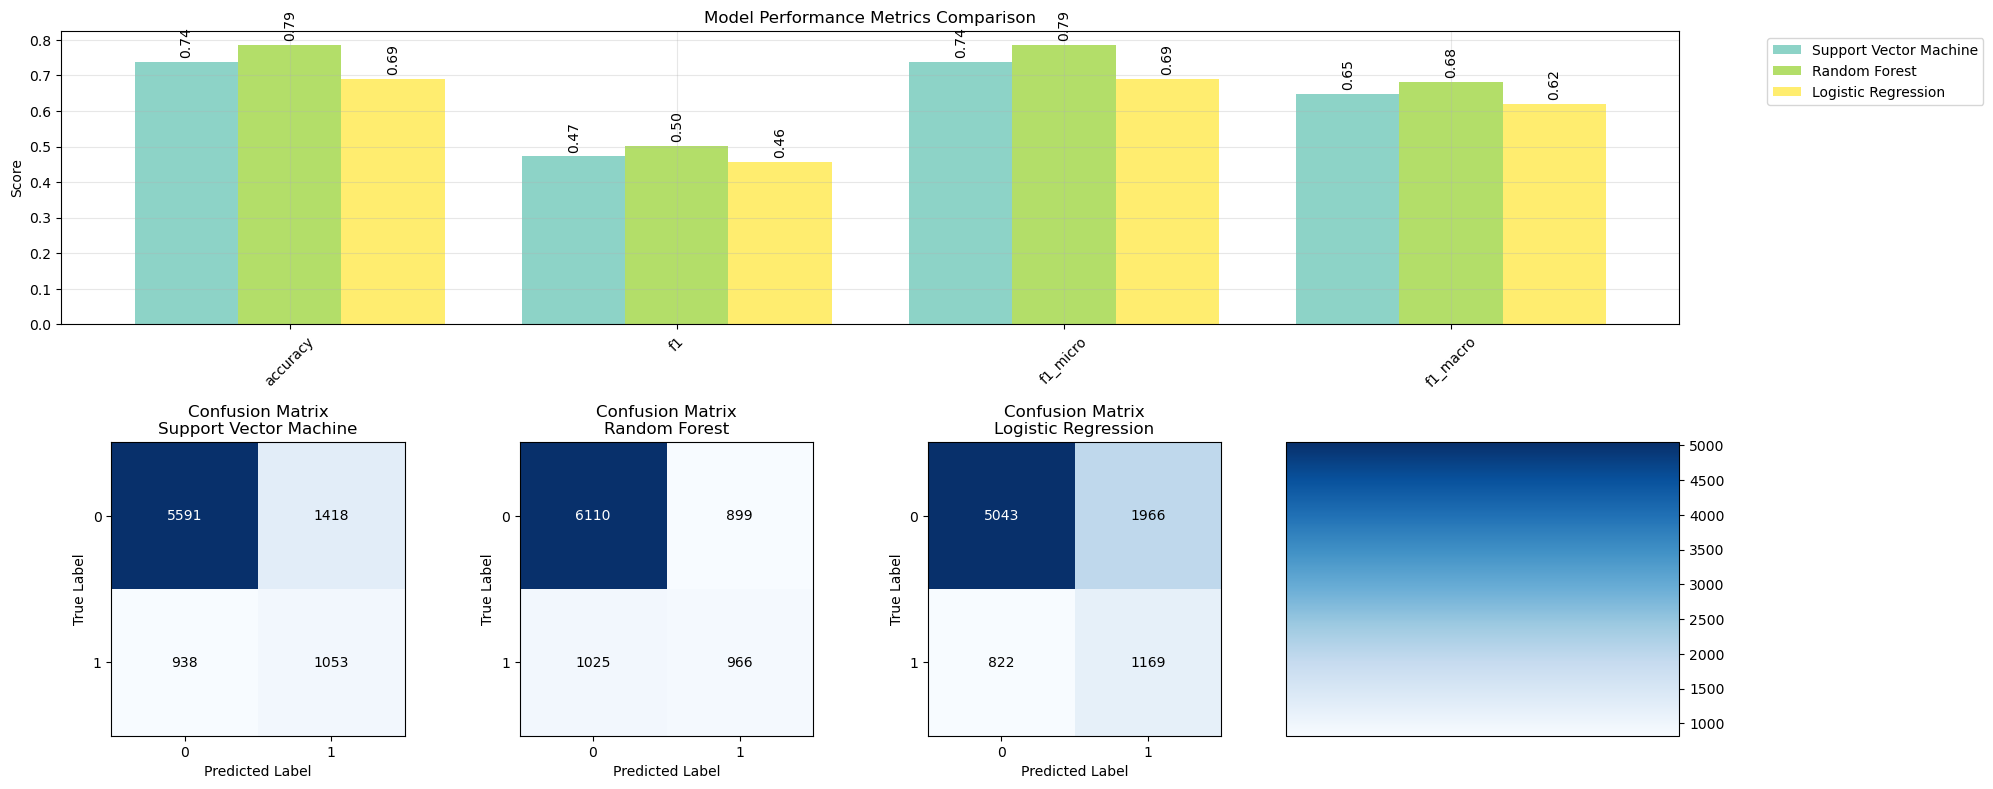

In [27]:
metrics = ['accuracy', 'f1', 'f1_micro', 'f1_macro']

scores = {}
for model_name, model_data in all_results_improved.items():
    scores[model_name] = [
        model_data['all_scores']['accuracy'],
        model_data['all_scores']['f1'],
        model_data['all_scores']['f1_micro'],
        model_data['all_scores']['f1_macro']
    ]

num_models = len(all_results_improved)
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, num_models + 1)

ax1 = fig.add_subplot(gs[0, :])

x = np.arange(len(metrics))
width = 0.8 / num_models  # Adjust bar width based on number of models
colors = plt.cm.Set3(np.linspace(0, 1, num_models))

for i, (model_name, model_scores) in enumerate(scores.items()):
    positions = x + width * (i - num_models/2 + 0.5)
    bars = ax1.bar(positions, model_scores, width, label=model_name, color=colors[i])
    
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)

ax1.set_ylabel('Score')
ax1.set_title('Model Performance Metrics Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

for i, (model_name, model_data) in enumerate(all_results_improved.items()):
    ax = fig.add_subplot(gs[1, i])
    conf_matrix = model_data['confusion_matrix']
    
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix\n{model_name}')
    
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

cbar_ax = fig.add_subplot(gs[1, -1])
plt.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()

## Redo the features importances things

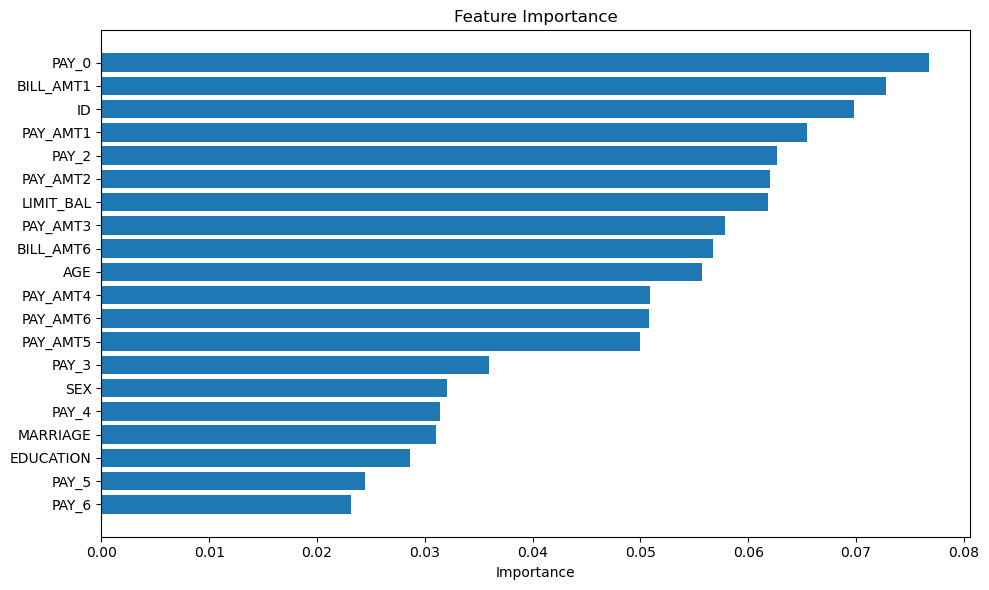

In [28]:
best_model_name = 'Random Forest'

best_model = best_models_improved[best_model_name].named_steps['rf']

importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=True)  # Ascending=True for horizontal bars to show highest at top

plt.figure(figsize=(10, 6))
plt.barh(importances_sorted.index, importances_sorted.values)

plt.title('Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()

## Redo the SHAP

In [29]:
explainer = shap.TreeExplainer(best_model)

In [30]:
shap_values = explainer.shap_values(X_test[:100])

<module 'matplotlib.pyplot' from '/nix/store/xih25y1md26h09z7qg5gh3k0kjmpz3js-python3-3.12.8-env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

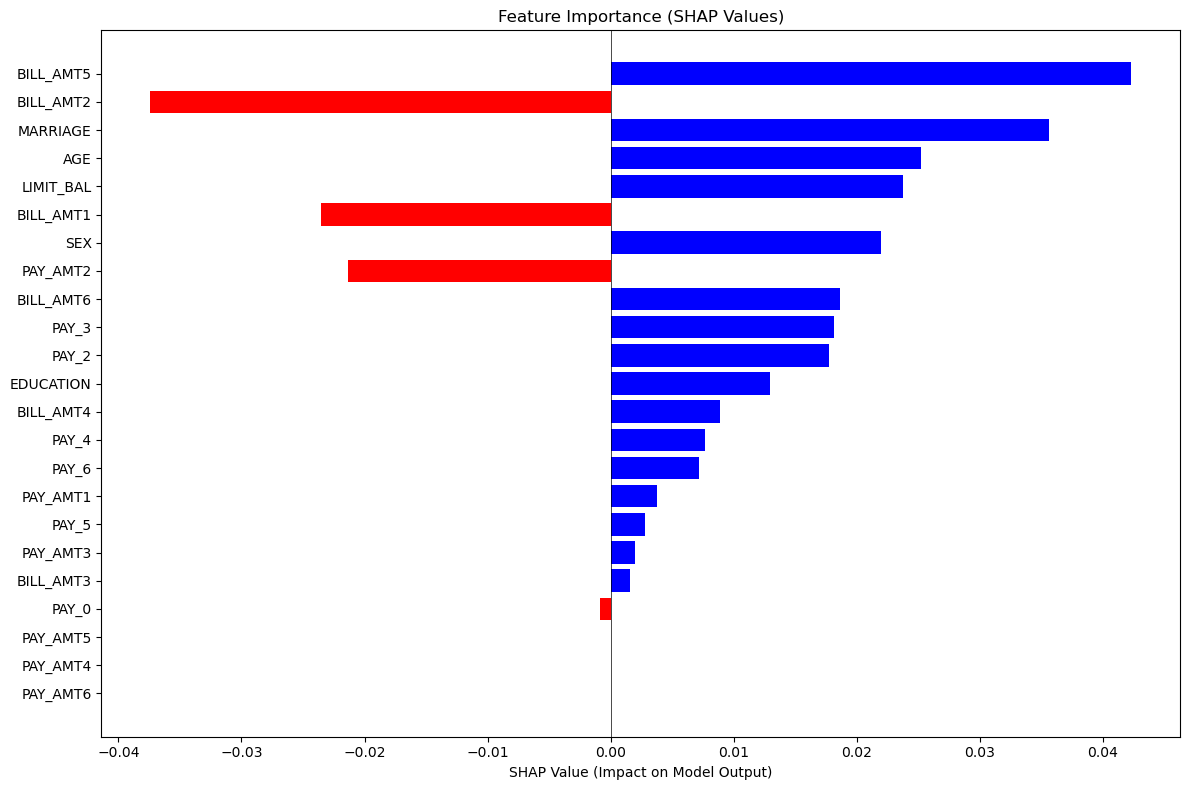

In [31]:
def plot_shap_values(shap_values, feature_names):
    values = shap_values[0][:, 0]
    
    plt.figure(figsize=(12, 8))
    
    sorted_idx = np.argsort(np.abs(values))
    
    y_pos = np.arange(len(values))
    plt.barh(y_pos, values[sorted_idx], 
            color=['red' if x < 0 else 'blue' for x in values[sorted_idx]])
    
    plt.yticks(y_pos, feature_names[sorted_idx], ha='right')
    plt.xlabel('SHAP Value (Impact on Model Output)')
    plt.title('Feature Importance (SHAP Values)')
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    return plt

plot_shap_values(shap_values, X_test.columns)

# 7. Conclusion

We observed in the metrics that an imbalanced dataset affected the class prediction. After applying SMOTE, the dataset became balanced and the predictions became more accurate.

We also removed features that were highly correlated with others. We are unsure of the impact since we don't know which metrics could provide this information.

Finally, the model performed well with acceptable accuracy and F1 scores.